# Spectral Density Computations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## Part 1: Define the activation function

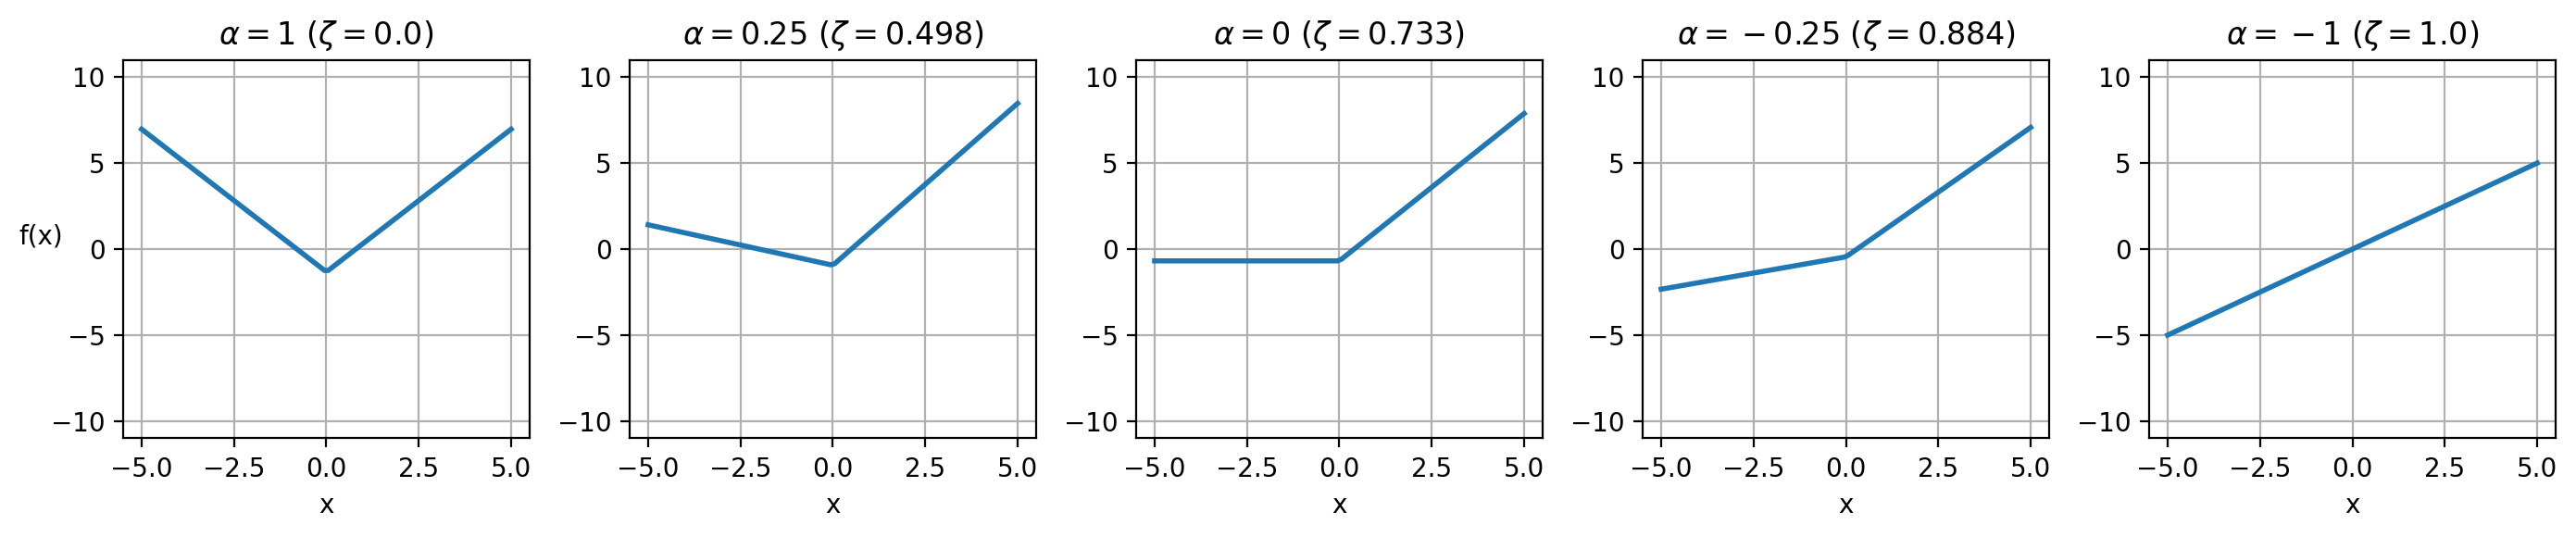

In [2]:
def relu(x):
    return np.maximum(x, 0)

def relu_modified(x, alpha):
    scale = np.sqrt(0.5 * (1 + alpha ** 2) - 0.5 * (1 / np.pi) * (1 + alpha) ** 2)
    return (relu(x) + alpha * relu(-x) - (1 + alpha) / np.sqrt(2 * np.pi)) / scale

def compute_zeta(alpha):
    return (1 - alpha) ** 2 / (2 * (1 + alpha ** 2) - (2 / np.pi) * (1 + alpha) ** 2)

plt.figure(figsize=(14, 3), dpi=200)
x = np.linspace(-5, 5, 100)

for i, alpha in enumerate([1, 0.25, 0, -0.25, -1]):

    plt.subplot(1, 5, i + 1)
    title = "$\\alpha = {}$ $(\\zeta = {})$"
    plt.title(title.format(alpha, np.round(compute_zeta(alpha), decimals=3)))
    plt.plot(x, relu_modified(x, alpha), lw=2)
    plt.ylim([-11, 11])
    plt.xlabel("x")
    plt.grid()

    if i == 0:
        plt.ylabel("f(x)", rotation=0)

plt.tight_layout()
plt.show()

## Part 2: Build data matrices

In [3]:
def build_X(n0, m, sigma_x, seed=None):
    rng = np.random.default_rng(seed=seed)
    return sigma_x * rng.standard_normal(size=(n0, m))

def build_W(n0, n1, sigma_w, seed=None):
    rng = np.random.default_rng(seed=seed)
    return (sigma_w / np.sqrt(n0)) * rng.standard_normal(size=(n1, n0))

# Choose data dimension parameters:
n0 = 10  # data matrix size
phi = 1  # size ratio for X
psi = 1  # size ratio for W

m = int(n0 / phi)
n1 = int(n0 / psi)

# Choose standard deviations:
sigma_x = 1
sigma_w = 1

# Choose an activation function:
f = lambda x: relu_modified(x, alpha=1)

# Build matrices:
X = build_X(n0, m, sigma_x)
W = build_W(n0, n1, sigma_w)
Y = f(W.dot(X))
M = (1 / m) * Y.dot(Y.T)

## Part 3: Compute the empirical density

100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


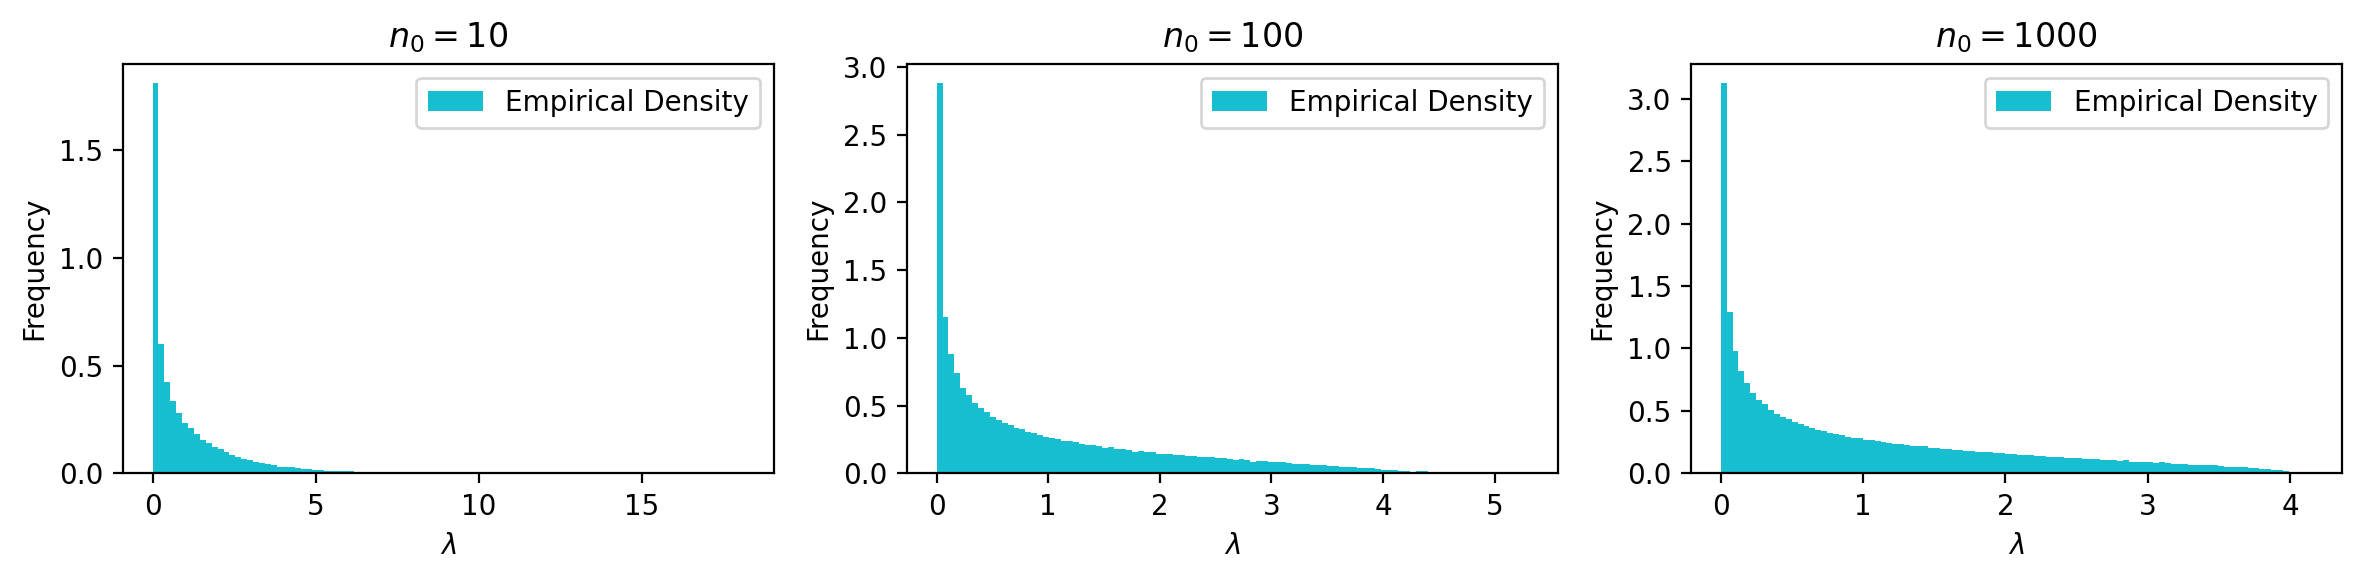

In [4]:
def build_gram(n0, f, phi=1, psi=1, sigma_x=1, sigma_w=1):
    m = int(n0 / phi)
    n1 = int(n0 / psi)
    X = build_X(n0, m, sigma_x)
    W = build_W(n0, n1, sigma_w)
    Y = f(W.dot(X))
    M = (1 / m) * Y.dot(Y.T)
    return M

all_eigs = []
n0_vals = np.logspace(1, 3, 3).astype(int)

f = lambda x: relu_modified(x, alpha=1)

for i, n0 in enumerate(n0_vals):
    all_eigs_i = []
    num_trials = int(1e+5 / n0)
    for _ in tqdm(range(num_trials)):
        M = build_gram(n0, f)
        all_eigs_i.append(np.linalg.eigh(M)[0]) # Gram matrix is symmetric

    all_eigs.append(all_eigs_i)

# Plot the empirical densities.
plt.figure(figsize=(12, 3), dpi=200)
for i, (n0, eigs) in enumerate(zip(n0_vals, all_eigs)):
    plt.subplot(1, len(n0_vals), i + 1)
    plt.hist(
        np.array(eigs).flatten(),
        density=True,
        bins=100,
        color="tab:cyan",
        label="Empirical Density",
    )
    plt.title(f"$n_0 = {n0}$")
    plt.xlabel("$\\lambda$")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

## Part 4: Compute the theoretical density $(\zeta = 0)$
Choose $\phi = \psi = 1$ for simplicity.

$$
\eta z\big[G(z)\big]^2 - z\big[G(z)\big] + 1 = 0
$$

$$
G(z) = \frac{z \pm \sqrt{z^2 - 4 z}}{2 z}, \quad \eta = 1
$$

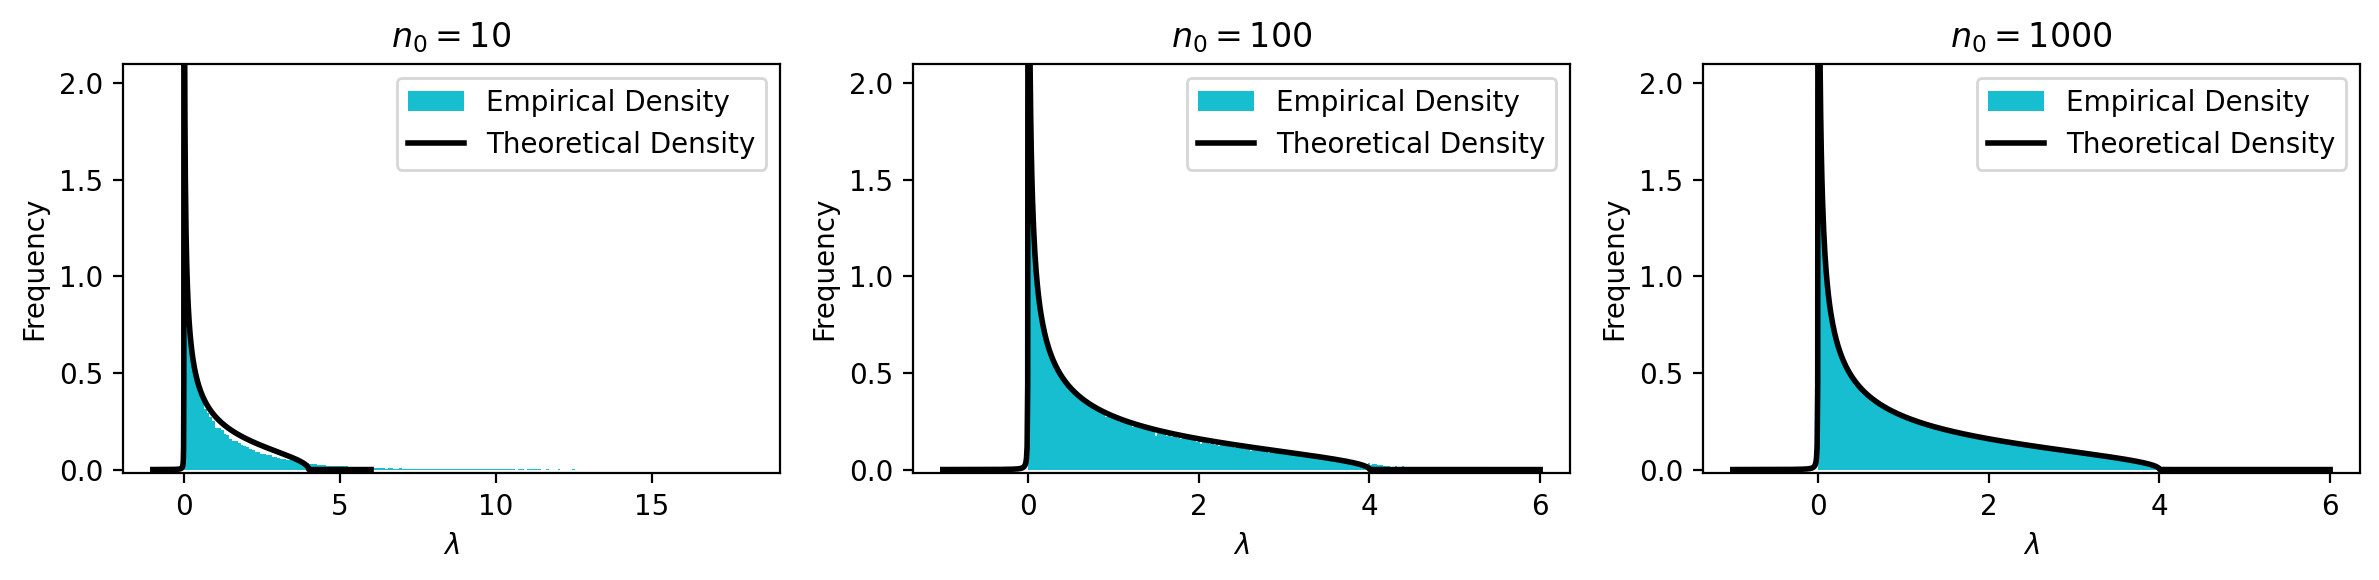

In [9]:
def G_0(z):
    """
    True theoretical G(z) for the zeta = 0 case.
    """
    G_pos = (z + np.sqrt(z ** 2 - 4 * z)) / (2 * z)
    G_neg = (z - np.sqrt(z ** 2 - 4 * z)) / (2 * z)

    G = []
    for i, (Gp,Gn) in enumerate(zip(G_pos,G_neg)):
        if Gp.imag < Gn.imag:
            G.append(Gp)
        else: 
            G.append(Gn)
    return np.array(G)

def spectral_density(z):
    G = G_0(z)
    return -(1 / np.pi) * G.imag

# Compute G(z) for z real on [-1, 6].
z = np.linspace(-1, 6, 1000).astype("complex") + (1j * 1e-3)
true_density = spectral_density(z)

# Plot the empirical densities vs. theoretical.
plt.figure(figsize=(12, 3), dpi=200)
for i, (n0, eigs) in enumerate(zip(n0_vals, all_eigs)):
    plt.subplot(1, len(n0_vals), i + 1)

    # (1) Empirical.
    plt.hist(
        np.array(eigs).flatten(),
        density=True,
        bins=200,
        color="tab:cyan",
        label="Empirical Density"
    )

    # (2) Theoretical.
    plt.plot(z.real, true_density, lw=2, c="k", label="Theoretical Density")

    plt.ylim([-0.02, 2.1])
    plt.title(f"$n_0 = {n0}$")
    plt.xlabel("$\\lambda$")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

## Part 5: Compute the theoretical density $(\zeta \neq 0)$
Choose $\phi = \psi = 1$ for simplicity.

$$
z^2(\zeta^2-\eta \zeta) \big[G(z)\big]^4 + z^2 \zeta \big[G(z)\big]^3 + z(\eta - \zeta)\big[G(z)\big]^2 - z\big[G(z)\big] + 1 = 0
$$

$$
h(G) := z^2(\zeta^2-\eta \zeta) G^4 + z^2 \zeta G^3 + z(\eta - \zeta)G^2 - zG + 1 = 0
$$

In [59]:
# Choose the new activation function:
alpha = 0.5
zeta = compute_zeta(alpha)
eta = 1
f = lambda x: relu_modified(x, alpha)

In [60]:
zeta, eta

(0.234168892113684, 1)

In [61]:
def G_0_mesh(z):
    """
    True theoretical G(z) for the zeta = 0 case.
    """
    G_pos = (z + np.sqrt(z ** 2 - 4 * z)) / (2 * z)
    G_neg = (z - np.sqrt(z ** 2 - 4 * z)) / (2 * z)

    G = np.zeros(z.shape).astype("complex")
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            if G_pos[i,j].imag < G_neg[i,j].imag:
                G[i,j] = G_pos[i,j]
            else: 
                G[i,j] = G_neg[i,j]
    return G

In [69]:
# USE NEWTON'S METHOD TO EVALUATE G AT VARIOUS Z:
def h(G, z, zeta, eta):
    hG = (z ** 2) * (zeta ** 2 - eta * zeta) * (G ** 4)
    hG += (z ** 2) * zeta * (G ** 3)
    hG += z * (eta - zeta) * (G ** 2)
    hG += 1 - z * G
    return hG

def h_prime(G, z, zeta, eta):
    hpG = 4 * (z ** 2) * (zeta ** 2 - eta * zeta) * (G ** 3)
    hpG += 3 * (z ** 2) * zeta * (G ** 2)
    hpG += 2 * z * (eta - zeta) * G - z
    return hpG

def Newton(G0, z, zeta, eta, tol=1e-12):
    G = G0
    err = tol + 1.0
    while err > tol:
        hG = h(G, z, zeta, eta)
        hpG = h_prime(G, z, zeta, eta)

        if hpG < 1e-16:
            G = np.random.randn(1)[0] + 1j * np.random.randn(1)[0]
        else:
            G_new = G - hG / hpG
            err = np.abs(G - G_new)
            G = G_new

    return G

# Define grid at which to evaluate G(z).
# Define a grid for Re(z) and Im(z).
zx = np.linspace(-1, 10, 500) # Re(z)
zy = np.concatenate([np.array([0,]), np.logspace(-16, -1, 16)]) # Im(z)
# zy = np.logspace(-16, -1, 16) 
ZX, ZY = np.meshgrid(zx, zy)
Z = ZX + 1j * ZY # x + iy

# Initialize the routine with G(Z) for zeta = 0.
G0 = G_0_mesh(Z)


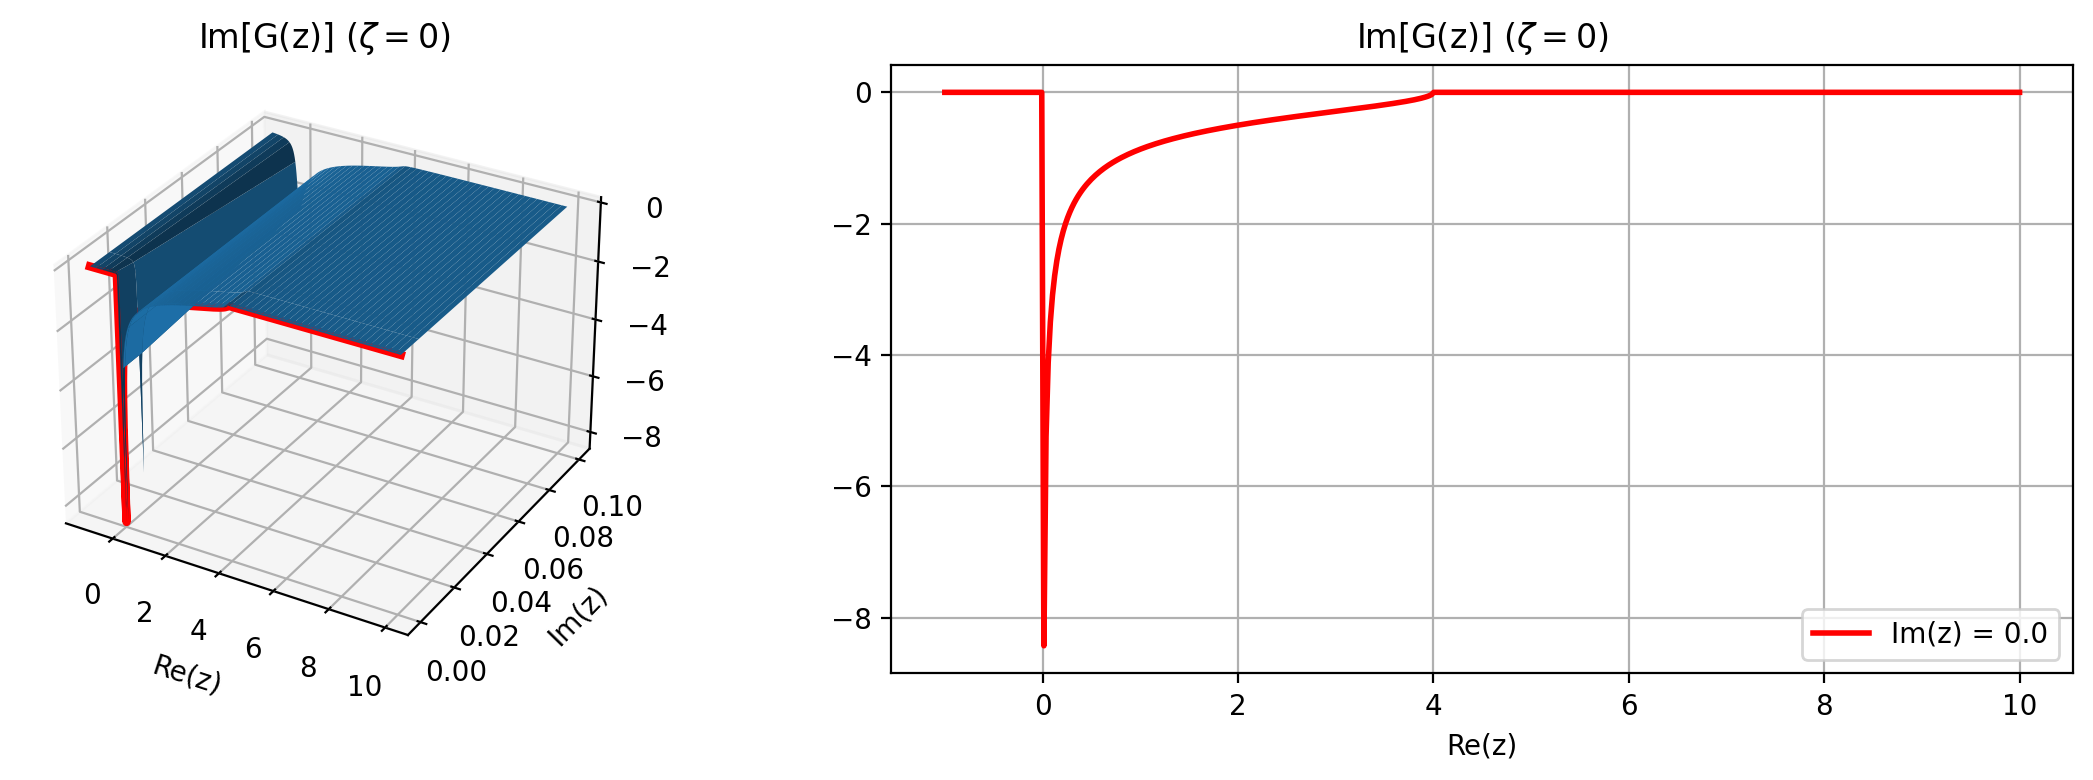

In [70]:

# Plot the initial conditions for G(z):
fig = plt.figure(figsize=(12, 4), dpi=200)

# Plot as 3-D surface plot.
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(ZX, ZY, G0.imag)
ax.plot(zx, G0[0].imag, zs=0, zdir="y", c="r", lw=3)
ax.set_xlabel("Re(z)")
ax.set_ylabel("Im(z)")
ax.set_title("Im[G(z)] ($\\zeta = 0$)")
# ax.set_ylim(zy.max(), zy.min()) # flip y direction

# Plot the Im(z) = 0 case in 2-D.
ax = fig.add_subplot(122)
ax.plot(zx, G0[0].imag, c="r", lw=2, label=f"Im(z) = {zy[0]}")
#ax.plot(zx, G0[1].imag, c="b", lw=2, label=f"Im(z) = {zy[1]}")
#ax.plot(zx, G0[2].imag, c="b", lw=2, label=f"Im(z) = {zy[2]}")
ax.set_xlabel("Re(z)")
ax.set_title("Im[G(z)] ($\\zeta = 0$)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

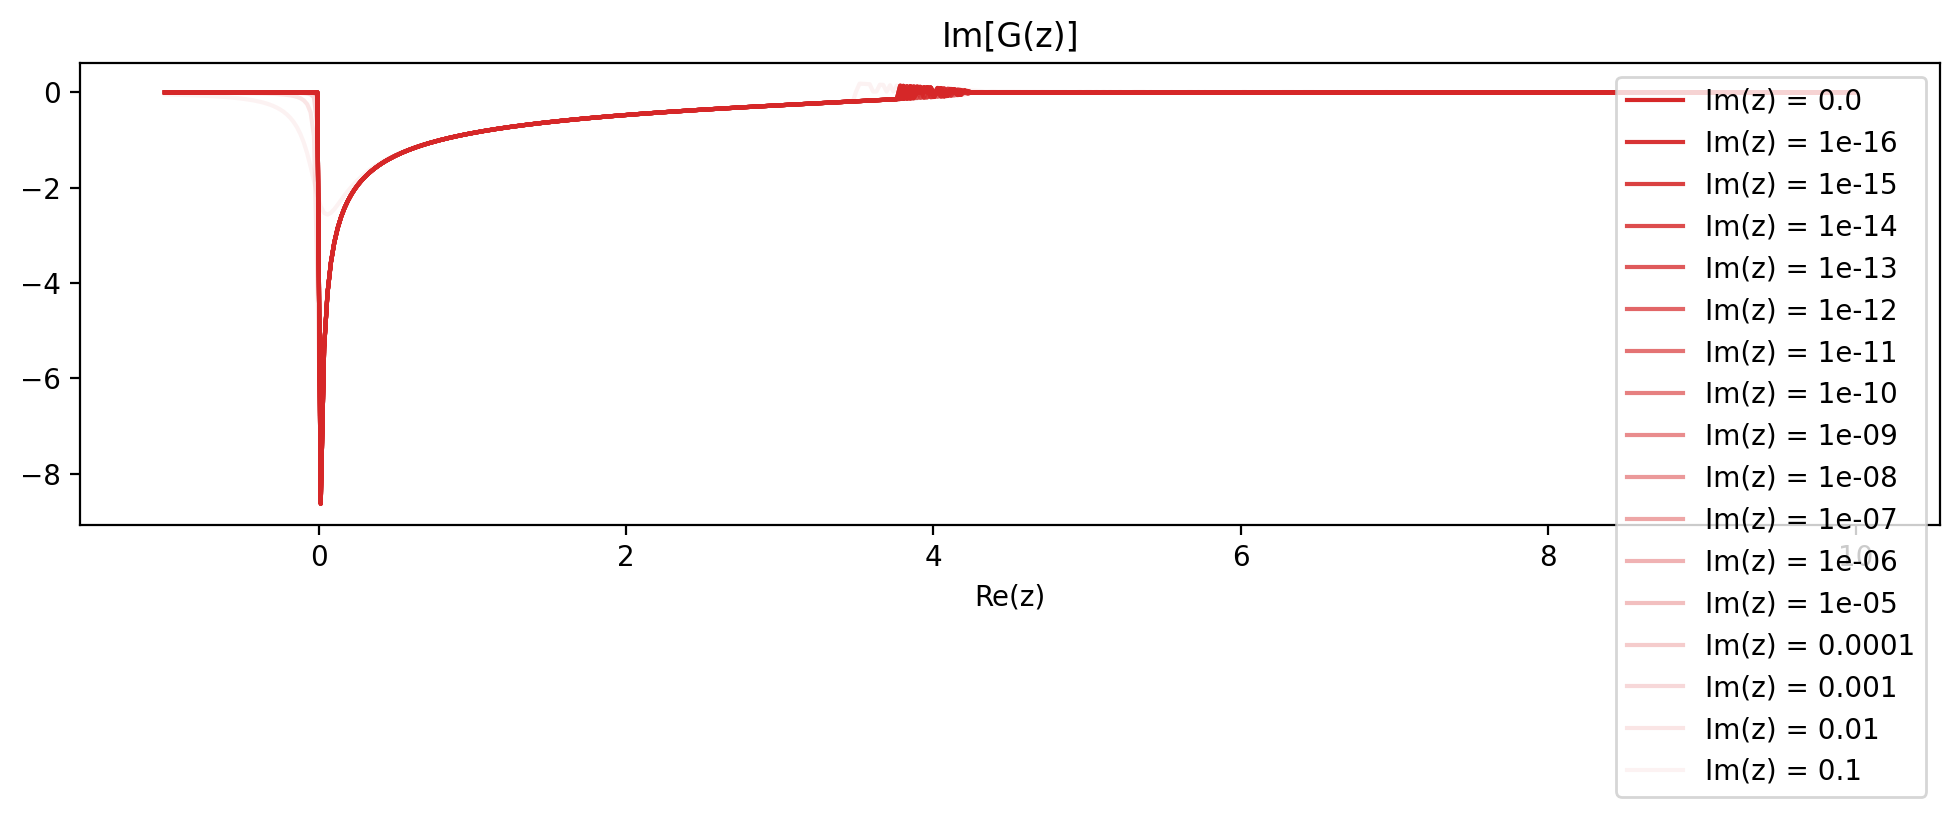

In [71]:
# Evaluate G(z) on the Z grid.
GZ = np.empty(Z.shape, dtype="complex")

for i in range(len(zy)):
    for j in range(len(zx)):
        GZ[i, j] = Newton(G0[i, j], Z[i, j], zeta, eta)

plt.figure(figsize=(12, 3), dpi=200)
for i in range(len(zy)):
    plt.plot(zx, GZ[i].imag, label=f"Im(z) = {zy[i]}", c="tab:red", alpha=1-i/len(zy))
    plt.xlabel("Re(z)")
    plt.title("Im[G(z)]")
plt.legend()
plt.show()

Text(0.5, 0.92, 'Im[G(z)] ($\\zeta = 0.234168892113684$)')

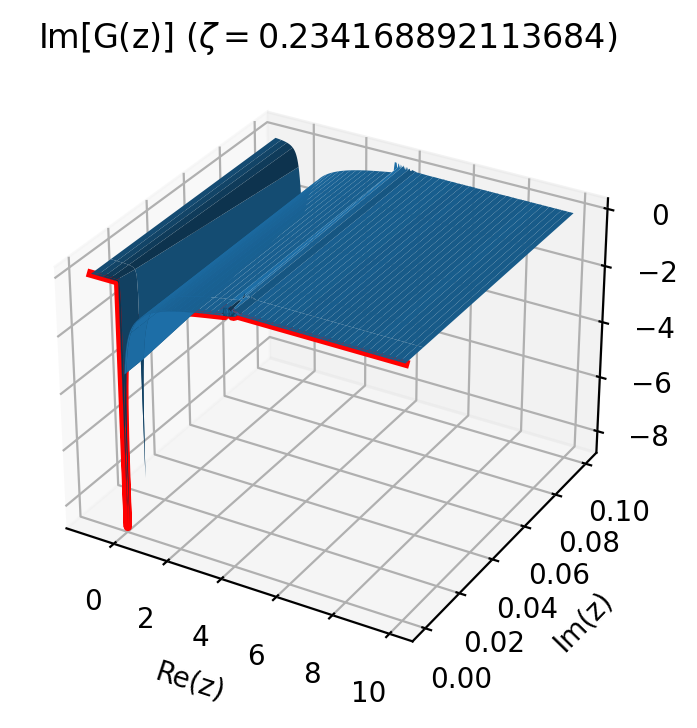

In [72]:
# Plot the initial conditions for G(z):
fig = plt.figure(figsize=(12, 4), dpi=200)

# Plot as 3-D surface plot.
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(ZX, ZY, GZ.imag)
ax.plot(zx, GZ[0].imag, zs=0, zdir="y", c="r", lw=3)
ax.set_xlabel("Re(z)")
ax.set_ylabel("Im(z)")
ax.set_title(f"Im[G(z)] ($\\zeta = {zeta}$)")
# ax.set_ylim(zy.max(), zy.min()) # flip y direction

100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


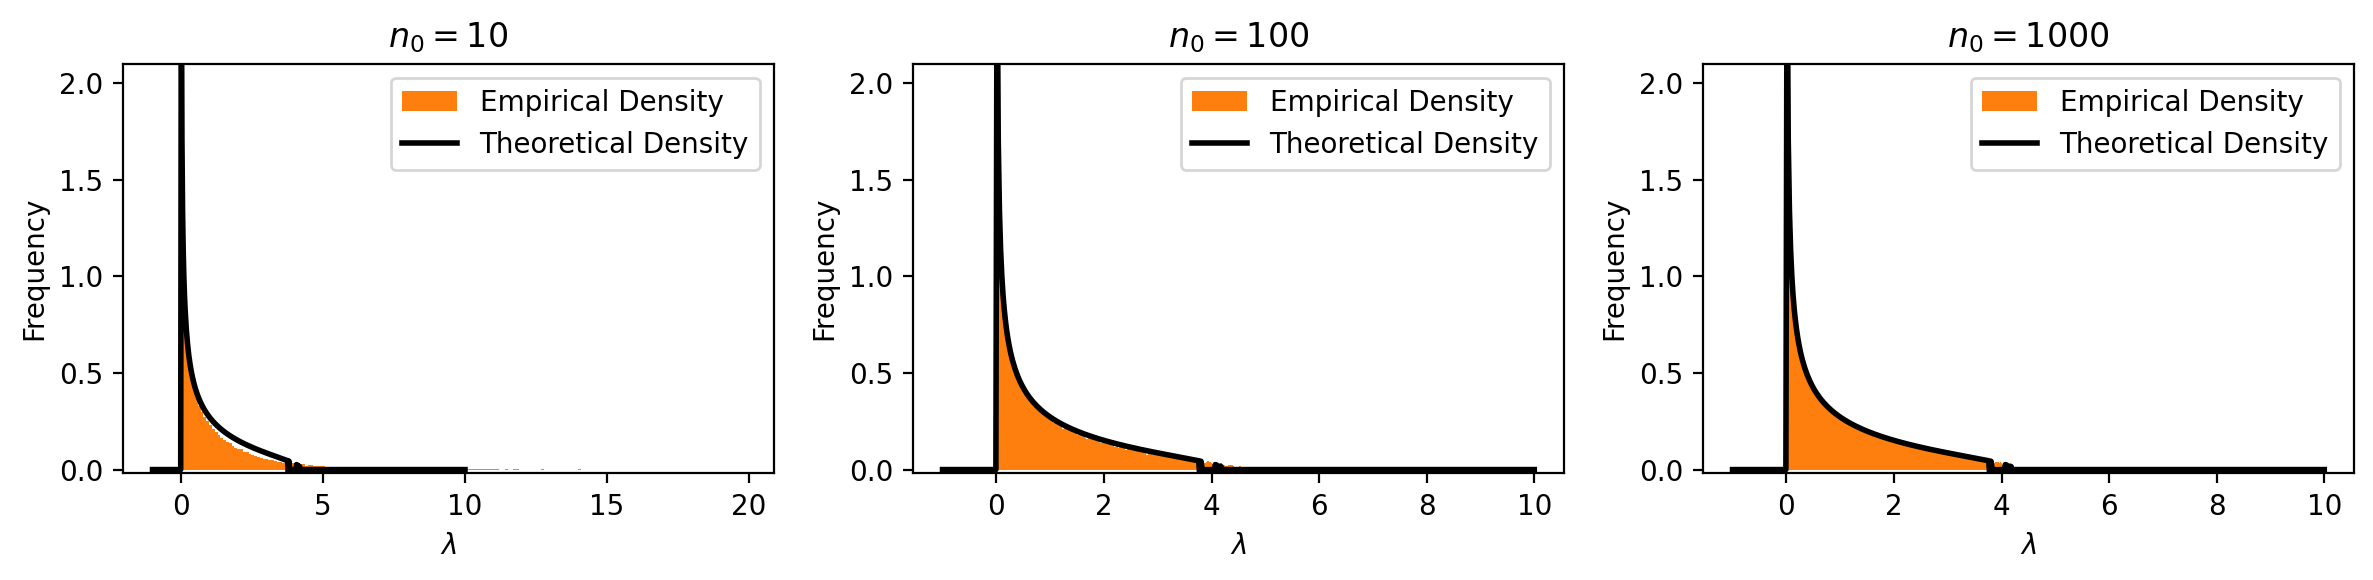

In [73]:
# Compute the new empirical distribution:
all_eigs = []
n0_vals = np.logspace(1, 3, 3).astype(int)

for i, n0 in enumerate(n0_vals):
    all_eigs_i = []
    num_trials = int(1e+5 / n0)
    for _ in tqdm(range(num_trials)):
        M = build_gram(n0, f)
        all_eigs_i.append(np.linalg.eigh(M)[0])

    all_eigs.append(all_eigs_i)

# Plot the empirical densities vs. theoretical.
true_density = -(1 / np.pi) * GZ[0].imag

plt.figure(figsize=(12, 3), dpi=200)
for i, (n0, eigs) in enumerate(zip(n0_vals, all_eigs)):
    plt.subplot(1, len(n0_vals), i + 1)

    # (1) Empirical.
    plt.hist(
        np.array(eigs).flatten(),
        density=True,
        bins=200,
        color="tab:orange",
        label="Empirical Density"
    )

    # (2) Theoretical.
    plt.plot(zx, true_density, lw=2, c="k", label="Theoretical Density")

    plt.ylim([-0.02, 2.1])
    plt.title(f"$n_0 = {n0}$")
    plt.xlabel("$\\lambda$")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()